# Tensorflow speech recognition challenge (Kaggle)

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from collections import Counter
import random
from sklearn.model_selection import train_test_split
from scipy import signal
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Input, layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm, trange
tf.__version__

'2.2.0'

In [42]:
data_path = "drive/My Drive/Colab Notebooks/data/preprocessed"
os.listdir(data_path)

['wav_all.npy',
 'label_all.npy',
 'unknown_wav.npy',
 'background_wav.npy',
 'test_wav_final.npy',
 'model-089-0.875049.h5',
 'best_val_model.hdf5',
 'best_deepspeech.hdf5',
 'Kopia best_val_model.hdf5',
 'Kopia best_deepspeech.hdf5',
 'test_wav_16000.npy',
 'sample_1600']

In [0]:
wav_all = np.load(os.path.join(data_path, "wav_all.npy"), allow_pickle=True)
wav_all = np.array([list(arr) for arr in wav_all])

label_all = np.load(os.path.join(data_path, "label_all.npy")).reshape(-1)

unknown_wav = np.load(os.path.join(data_path, "unknown_wav.npy"))
background_wav = np.load(os.path.join(data_path, "background_wav.npy"), allow_pickle=True)

---
### Generating training data
#### Generating silence samples from background noise
Since we have around 2131 of every label in our dataset, we will generate 2131 additional samples from background noise (and label it silence, because it doesn't contain any speech).

In [0]:
n_silence_samples = 41115

In [0]:
def get_noise_sample(noise_num=0):
    """Gets random sample from selected noise type (one out of 6)"""
    selected_noise = background_wav[noise_num]
    start_idx = random.randint(0, len(selected_noise)- 1 - 8000)
    return selected_noise[start_idx:(start_idx + 8000)]

In [46]:
#silence audio
silence_wav = []
n_samples_per_noise = n_silence_samples // len(background_wav)
for i, _ in enumerate(background_wav):
    for _ in range(n_samples_per_noise):
        silence_wav.append(get_noise_sample(i))
silence_wav = np.array(silence_wav)
silence_label = np.array(['silence' for _ in range(n_samples_per_noise * len(background_wav))])
silence_wav.shape

(41112, 8000)

#### Creating samples of unknown speech
Samples form all other labels. 

In [0]:
unknown_wav = np.array(random.sample(list(unknown_wav), n_silence_samples))
unknown_label = ["unknown" for _ in range(n_silence_samples)]

---
#### Data Processing pipeline
The next step would be to create data processing pipeline: sample elements from the whole dataset instead of choosing fixed set of unknown samples and also doing data aumentation (mixing with noise) when doing training.

In [0]:
data = np.concatenate([wav_all, unknown_wav, silence_wav], 0)
labels = np.concatenate([label_all, unknown_label, silence_label], 0)
del(wav_all)
del(unknown_wav)
del(silence_wav)

In [49]:
# Converting labels to one hot vectors
label_values = np.unique(labels)
label_dict = {label: value for value, label in enumerate(sorted(label_values))}
label_dict

{'down': 0,
 'go': 1,
 'left': 2,
 'no': 3,
 'off': 4,
 'on': 5,
 'right': 6,
 'silence': 7,
 'stop': 8,
 'unknown': 9,
 'up': 10,
 'yes': 11}

In [50]:
label_all = [label_dict[label] for label in labels]
label_all = keras.utils.to_categorical(label_all, len(label_dict)).reshape(-1, 12, 1)
label_all.shape

(103539, 12, 1)

In [0]:
train_wav, test_wav, train_label, test_label = train_test_split(data, label_all, test_size=0.1, random_state=42, shuffle=True)
del(data)  # saving RAM space

#### Spectogram

In [0]:
def log_specgram(audio, sample_rate=8000, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))

    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    logspec = np.log(spec.T.astype(np.float32) + eps)
    return logspec.reshape(*logspec.shape, 1)

In [0]:
# train_wav_spec = np.array([log_specgram(x) for x in tqdm(train_wav)])
# test_wav_spec = np.array([log_specgram(x) for x in tqdm(test_wav)])

In [0]:
def get_noise_sample(noise_num=0):
    """Gets random sample from selected noise type (one out of 6)"""
    selected_noise = background_wav[noise_num]
    start_idx = random.randint(0, len(selected_noise)- 1 - 8000)
    return selected_noise[start_idx:(start_idx + 8000)]

def augment_convert(x):
    noise_ratio = random.random()
    num = random.randint(0, 5)
    noise = get_noise_sample(num)
    noised_x = x + noise_ratio * noise
    return log_specgram(noised_x)
    # return tf.reshape(noised_x, [8000, 1])

def convert(x):
    return log_specgram(x)

In [0]:
kwargs = dict(deterministic=False, num_parallel_calls=-1)

x_train = tf.data.Dataset.from_tensor_slices(train_wav).map(lambda x: tf.py_function(func=augment_convert, inp=[x], Tout=tf.float32), **kwargs)
y_train = tf.data.Dataset.from_tensor_slices(train_label.reshape([-1, 12]))

x_test = tf.data.Dataset.from_tensor_slices(test_wav).map(lambda x: tf.py_function(func=convert, inp=[x], Tout=tf.float32), **kwargs)
y_test = tf.data.Dataset.from_tensor_slices(test_label.reshape([-1, 12]))

# next(iter(x_train)).shape

In [0]:
# Defining data augmentation pipeline
train_dataset = tf.data.Dataset.zip((x_train, y_train)).batch(512).prefetch(1000)
valid_dataset = tf.data.Dataset.zip((x_test, y_test)).batch(512).prefetch(1000)
# next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape

---
## Model

In [0]:
# Parameters
lr = 0.001
initial_lr = 0.001
batch_size = 1024
dropout_rate = 0.5
input_shape = (99, 81, 1)
best_model_path = '.best_val_model.hdf5'

# class weights
label_cnt = Counter(labels)
num_to_label = {value: key for key, value in label_dict.items()}
class_weight = {label_dict[key]: 2062 / value for key, value in label_cnt.items()}

In [0]:
def scheduler(epoch, lr):
    if epoch < 2:
        return 0.01
    elif epoch < 5:
        return 0.001
    else:
        return 0.0001

In [0]:
#Conv2D Model
input_tensor = Input(shape=(input_shape))

x = layers.BatchNormalization(axis=2)(input_tensor)

x = layers.Conv2D(16, (11,41), padding='valid', activation='relu', strides=1)(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(32, (11,21), padding='valid', activation='relu', strides=1)(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.BatchNormalization()(x)
# x = layers.MaxPooling2D(1, x.shape[2])(x)

# x = layers.Conv2D(32, (3,40), activation='relu')(x)
# x = layers.Dropout(dropout_rate)(x)
# x = layers.BatchNormalization()(x)
# x = layers.MaxPooling2D(1, x.shape[2])(x)

x = layers.Reshape((x.shape[1], x.shape[2]*x.shape[3]))(x)

# x = layers.Conv1D(16, 7, padding='valid', activation='relu', strides=1)(x)
# x = layers.MaxPooling1D(2)(x)
# x = layers.Dropout(dropout_rate)(x)
# x = layers.Conv1D(32, 5, padding='valid', activation='relu', strides=1)(x)
# x = layers.MaxPooling1D(10)(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = layers.BatchNormalization()(x)

x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.BatchNormalization()(x)

x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
x = layers.BatchNormalization()(x)

x = layers.Bidirectional(layers.LSTM(16, return_sequences=True))(x)
x = layers.BatchNormalization()(x)

x = layers.Flatten()(x)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(dropout_rate)(x)
# x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.BatchNormalization()(x)

output_tensor = layers.Dense(12, activation='softmax')(x)

model = tf.keras.Model(input_tensor, output_tensor)
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(lr=lr),
             metrics=['accuracy'])

best_model_path = os.path.join(data_path, "best_val_model.hdf5")
mcp_save = ModelCheckpoint(best_model_path, save_best_only=True, monitor='val_loss', mode='min')

In [61]:
# Starting training from scratch
# schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(train_dataset, validation_data=valid_dataset, class_weight=class_weight, shuffle=True, epochs=1, verbose=1, callbacks=[mcp_save])

183/183 [==============================] - 288s 2s/step - loss: 0.6383 - accuracy: 0.1381 - val_loss: 2.7319 - val_accuracy: 0.0217


In [0]:
# Traininig continuation
model = keras.models.load_model(best_model_path)

In [0]:
model.optimizer.lr = 0.001
model.optimizer.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

In [0]:
history = model.fit(train_dataset, validation_data=valid_dataset, class_weight=class_weight, shuffle=True, epochs=100, verbose=1, callbacks=[mcp_save])

Epoch 1/100
183/183 [==============================] - 414s 2s/step - loss: 0.3540 - accuracy: 0.6663 - val_loss: 0.8491 - val_accuracy: 0.8780
Epoch 2/100
183/183 [==============================] - 288s 2s/step - loss: 0.2239 - accuracy: 0.7722 - val_loss: 0.8639 - val_accuracy: 0.8717
Epoch 3/100
183/183 [==============================] - 291s 2s/step - loss: 0.2224 - accuracy: 0.7766 - val_loss: 0.7555 - val_accuracy: 0.8753
Epoch 4/100
183/183 [==============================] - 288s 2s/step - loss: 0.2175 - accuracy: 0.7819 - val_loss: 0.9601 - val_accuracy: 0.8525
Epoch 5/100
183/183 [==============================] - 287s 2s/step - loss: 0.2182 - accuracy: 0.7767 - val_loss: 0.8938 - val_accuracy: 0.8669
Epoch 6/100
183/183 [==============================] - 287s 2s/step - loss: 0.2158 - accuracy: 0.7835 - val_loss: 0.9036 - val_accuracy: 0.8689
Epoch 7/100
183/183 [==============================] - 287s 2s/step - loss: 0.2121 - accuracy: 0.7848 - val_loss: 0.8759 - val_accuracy:

In [0]:
best_model_path = os.path.join(data_path, "best_val_model.hdf5")
model = keras.models.load_model(best_model_path)

In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 99, 81, 1)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 99, 81, 1)         324       
_________________________________________________________________
conv2d (Conv2D)              (None, 89, 41, 16)        7232      
_________________________________________________________________
dropout (Dropout)            (None, 89, 41, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 89, 41, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 79, 21, 32)        118304    
_________________________________________________________________
dropout_1 (Dropout)          (None, 79, 21, 32)        0     

## Running model on test data

In [0]:
label_dict = {'down': 0,
            'go': 1,
            'left': 2,
            'no': 3,
            'off': 4,
            'on': 5,
            'right': 6,
            'silence': 7,
            'stop': 8,
            'unknown': 9,
            'up': 10,
            'yes': 11}

In [0]:
test_path = os.path.join(data_path, "test_wav_final.npy")
test_all = np.load(test_path)  # may take a while (~3 minutes) (it's almost 5GB)

In [0]:
del(train_wav_spec)
del(test_wav_spec)

In [0]:
n_steps = test_all.shape[0] // chunk_size
n_steps

154

In [0]:
preds_all = []
sample_rate = 8000
for i in trange(n_steps+1):
    if i==n_steps:
        spectograms_test = [log_specgram(np.squeeze(elem))\
                         for elem in test_all[i*chunk_size:]]
    else:
        spectograms_test = [log_specgram(np.squeeze(elem))\
                         for elem in test_all[i*chunk_size:i*chunk_size + chunk_size]]
    spectograms_test = np.asarray(spectograms_test)
    spectograms_test = np.expand_dims(spectograms_test, axis=3)
    preds_all.append(model.predict(spectograms_test))
preds = np.array([item for sublist in preds_all for item in sublist])

In [0]:
preds = np.array(preds)

In [0]:
num_to_label = {value: key for key, value in label_dict.items()}
num_to_label

{0: 'down',
 1: 'go',
 2: 'left',
 3: 'no',
 4: 'off',
 5: 'on',
 6: 'right',
 7: 'silence',
 8: 'stop',
 9: 'unknown',
 10: 'up',
 11: 'yes'}

In [0]:
predicted_labels = [num_to_label[num] for num in preds.argmax(1)]

In [0]:
submission_file = pd.read_csv(os.path.join(data_path, "sample_submission.csv"))
submission_file["label"] = predicted_labels
submission_file.to_csv(os.path.join(data_path, "submission.csv"), index=False)

In [0]:
pd.read_csv(os.path.join(data_path, "submission.csv")).head()

,fname,label
0,clip_000044442.wav,no
1,clip_0000adecb.wav,unknown
2,clip_0000d4322.wav,unknown
3,clip_0000fb6fe.wav,up
4,clip_0001d1559.wav,unknown


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text major ticklabel objects>)

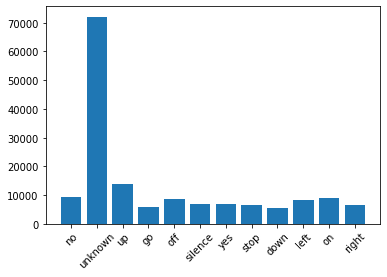

In [0]:
predicted_label_cnt = Counter(submission_file.label.values)
plt.bar(predicted_label_cnt.keys(), predicted_label_cnt.values())
plt.xticks(rotation=45)

In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 99, 81, 1)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 99, 81, 1)         324       
_________________________________________________________________
conv2d (Conv2D)              (None, 89, 41, 16)        7232      
_________________________________________________________________
dropout (Dropout)            (None, 89, 41, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 89, 41, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 79, 21, 32)        118304    
_________________________________________________________________
dropout_1 (Dropout)          (None, 79, 21, 32)        0     